In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization,Input, Flatten,  Conv1D, MaxPooling1D
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.ops import math_ops
from keras.optimizers import Adam
import keras
import tensorflow
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder 
import pandas_ta as ta
import tensorflow.experimental.numpy as tnp
import scipy.stats as stats
from nixtlats import TimeGPT
import graphviz, pydot

           Effective date  S&P Global High Yield Sukuk Index
0     2014-02-28 00:00:00                             102.12
1     2014-03-03 00:00:00                             102.41
2     2014-03-04 00:00:00                             102.12
3     2014-03-05 00:00:00                             102.17
4     2014-03-06 00:00:00                             102.08
...                   ...                                ...
2592  2024-02-27 00:00:00                             171.60
2593  2024-02-28 00:00:00                             171.65
2594  2024-02-29 00:00:00                             171.89
2595  2024-03-01 00:00:00                             172.00
2596  2024-03-04 00:00:00                             171.91

[2597 rows x 2 columns]


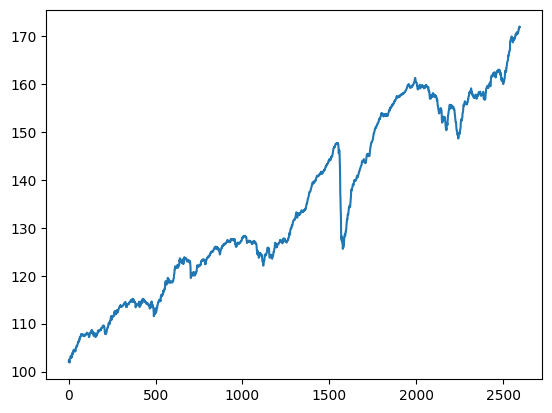

In [6]:
# Load data
folder_path = "CSV files/"
name = "S&P Global High Yield Sukuk Index"
data = pd.read_csv(folder_path + name + ".csv")
print(data) 
# Extract features (date) and target (price)v
X = data["Effective date"]
y = data[name]
pyplot.plot(data[name], label='Effective date')
pyplot.show()

In [7]:
# Adding indicators
data['RSI']=ta.rsi(data[name], length=15)
data['EMAF']=ta.ema(data[name], length=15)
data['EMAM']=ta.ema(data[name], length=90)
data['EMAS']=ta.ema(data[name], length=150)
data['Price_diff'] = data[name].diff()
data['EMAF_diff'] = data['EMAF'].diff()
data['Next_Price_diff'] = data[name].diff().shift(-1)
data['Next_EMAF_diff'] = data['EMAF'].diff().shift(-1)
data['Next_Price'] = data[name].shift(-1)
#data['Target'] = data['Adj Close']-data.Open
#data['Target'] = data['Target'].shift(-1)
#data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
#data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data

,index,Effective date,S&P Global High Yield Sukuk Index,RSI,EMAF,EMAM,EMAS,Price_diff,EMAF_diff,Next_Price_diff,Next_EMAF_diff,Next_Price
0,149,2014-09-25 00:00:00,108.05,52.002455,107.958205,107.235777,106.318333,0.09,0.013114,-0.14,-0.006026,107.91
1,150,2014-09-26 00:00:00,107.91,48.694004,107.952179,107.250595,106.339415,-0.14,-0.006026,-0.30,-0.042772,107.61
2,151,2014-09-29 00:00:00,107.61,42.487857,107.909407,107.258494,106.356244,-0.30,-0.042772,-0.25,-0.068676,107.36
3,152,2014-09-30 00:00:00,107.36,38.146879,107.840731,107.260725,106.369539,-0.25,-0.068676,0.08,-0.050091,107.44
4,153,2014-10-01 00:00:00,107.44,40.240243,107.790639,107.264665,106.383717,0.08,-0.050091,-0.22,-0.071330,107.22
...,...,...,...,...,...,...,...,...,...,...,...,...
2442,2591,2024-02-26 00:00:00,171.68,77.675656,170.799174,167.786537,165.841271,0.41,0.125832,-0.08,0.100103,171.60
2443,2592,2024-02-27 00:00:00,171.60,75.231433,170.899278,167.870349,165.917546,-0.08,0.100103,0.05,0.093840,171.65
2444,2593,2024-02-28 00:00:00,171.65,75.742578,170.993118,167.953419,165.993472,0.05,0.093840,0.24,0.112110,171.89
2445,2594,2024-02-29 00:00:00,171.89,78.070052,171.105228,168.039937,166.071572,0.24,0.112110,0.11,0.111846,172.00


In [8]:
print((data["Next_Price_diff"] > 0).sum())
print((data["Next_Price_diff"] < 0).sum())
print((data["Next_Price_diff"] == 0).sum())

positive = 0
negative = 0
nul = 0

for x in data["Next_Price_diff"]:
    if x > 0:
        positive += x
    elif x < 0:
        negative += x
    else:
        nul += x
print(positive)
print(negative)
print(nul)

print(positive + negative)
print(data[name][len(data)-1] - data[name][0])
data["Next_Price_diff"].describe()


1462
908
77
221.86999999999998
-158.01
0.0
63.859999999999985
63.95


count    2447.000000
mean        0.026097
std         0.258887
min        -3.980000
25%        -0.050000
50%         0.040000
75%         0.130000
max         1.610000
Name: Next_Price_diff, dtype: float64

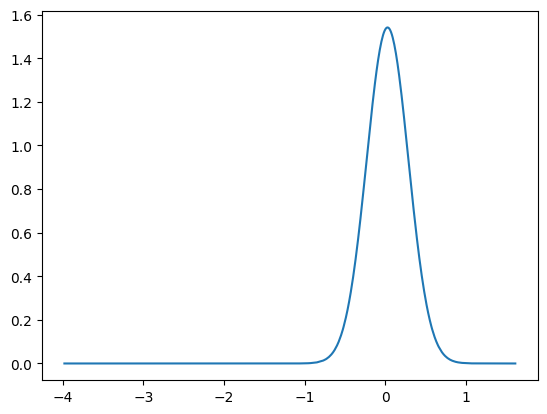

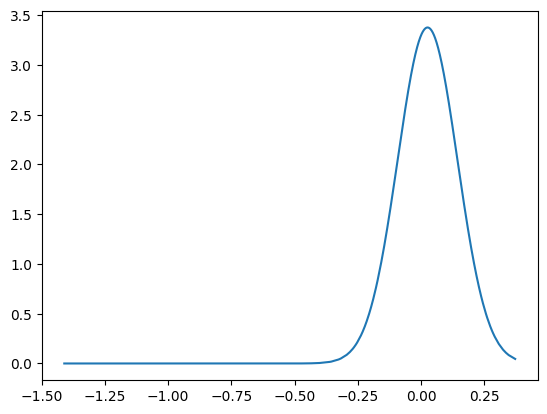

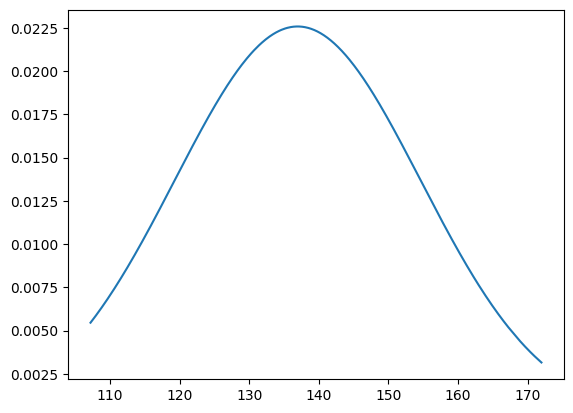

In [9]:
pdf = stats.norm.pdf(data['Next_Price_diff'].sort_values(), np.mean(data["Next_Price_diff"]), np.std(data["Next_Price_diff"]))
plt.plot(data['Next_Price_diff'].sort_values(), pdf)
plt.show()
pdf = stats.norm.pdf(data['Next_EMAF_diff'].sort_values(), np.mean(data['Next_EMAF_diff']), np.std(data['Next_EMAF_diff']))
plt.plot(data['Next_EMAF_diff'].sort_values(), pdf)
plt.show()
pdf = stats.norm.pdf(data['Next_Price'].sort_values(), np.mean(data['Next_Price']), np.std(data['Next_Price']))
plt.plot(data['Next_Price'].sort_values(), pdf)
plt.show()

In [6]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'eQgqY23AnClxUtounMajMKRrIxjRJcM5NeJYEsQdXCD30xJuj7RKEGdYngsTOae8fA7fEj37waf8Fm3zY8YHbLDwdkS2V1SVAmlMyHWjgguzGEs5nM75q0wnYo0YZHr5xAJmHPkpt6cDJTrgto6072DbKSFiPaSCobAmGPRUjGlt1mFXKxSIbusk4ZpO3ze794KrG95zhRZ72QFuaY3zvhnwclbo9Ll5DAHk38eR1dnaig03pOtMPsAOjkjNkisS'

)
timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [7]:
df = pd.read_csv('xx.csv')
df[0:200]

,Effective date,S&P Global High Yield Sukuk Index
0,2014-02-28 00:00:00,102.12
1,2014-03-03 00:00:00,102.41
2,2014-03-04 00:00:00,102.12
3,2014-03-05 00:00:00,102.17
4,2014-03-06 00:00:00,102.08
...,...,...
195,2014-11-28 00:00:00,109.51
196,2014-12-01 00:00:00,109.50
197,2014-12-02 00:00:00,109.43
198,2014-12-03 00:00:00,109.46


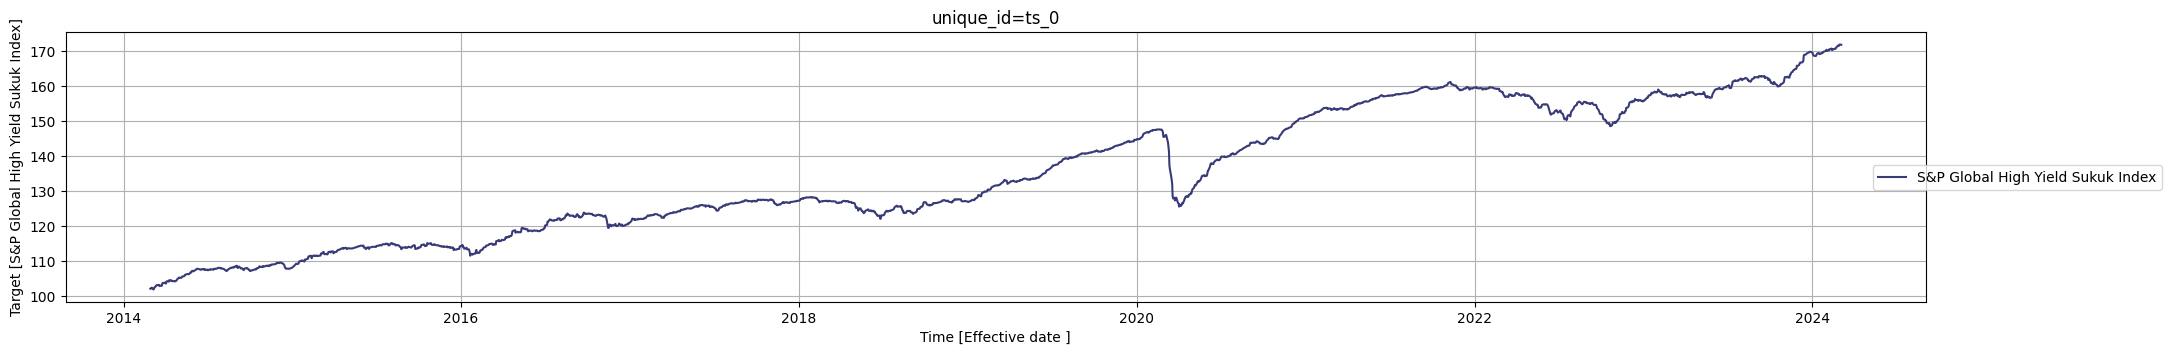

In [8]:
#df['Effective date'] = pd.to_datetime(df['Effective date'], format='%Y-%m-%d %H:%M:%S')
timegpt.plot(df, time_col='Effective date ', target_col=name)

In [9]:
timegpt_fcst_df = timegpt.forecast(df=df[0:-200], h=12, freq='MS', time_col='Effective date ', target_col=name)
timegpt_fcst_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,Effective date,TimeGPT
0,2023-06-01,158.059341
1,2023-07-01,158.103745
2,2023-08-01,158.414841
3,2023-09-01,159.033279
4,2023-10-01,158.429916


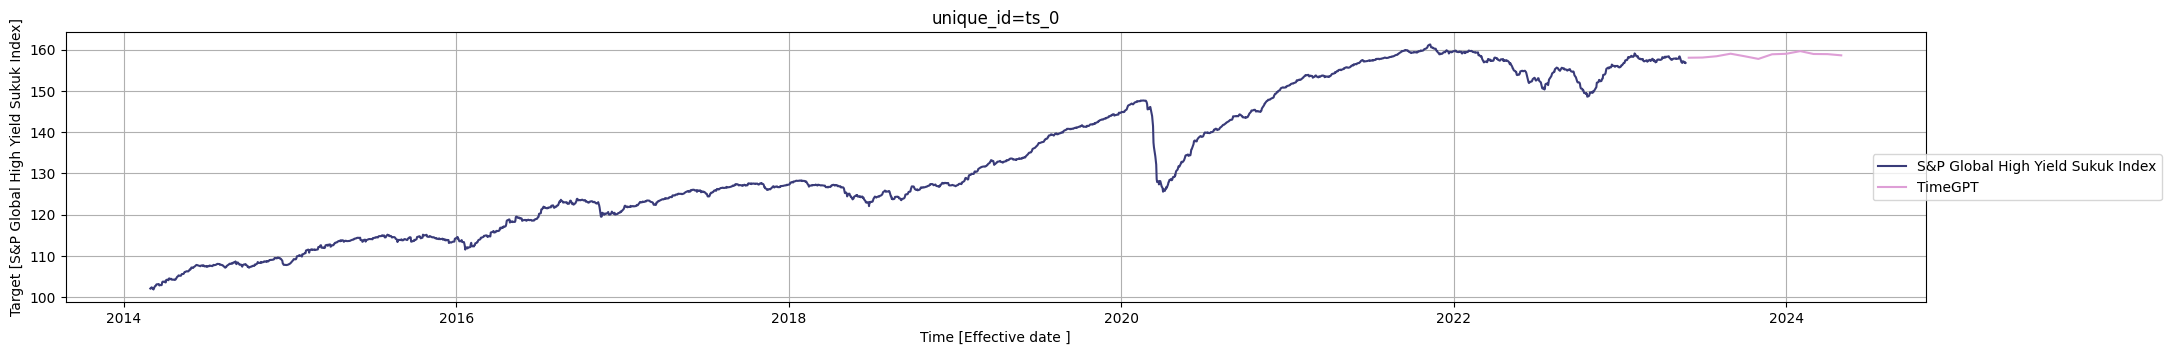

In [10]:
timegpt.plot(df[0:-200], timegpt_fcst_df, time_col='Effective date ', target_col='S&P Global High Yield Sukuk Index')

[[ 1.0805e+02  9.0000e-02  1.0791e+02]
 [ 1.0791e+02 -1.4000e-01  1.0761e+02]
 [ 1.0761e+02 -3.0000e-01  1.0736e+02]
 ...
 [ 1.7165e+02  5.0000e-02  1.7189e+02]
 [ 1.7189e+02  2.4000e-01  1.7200e+02]
 [ 1.7200e+02  1.1000e-01  1.7191e+02]]


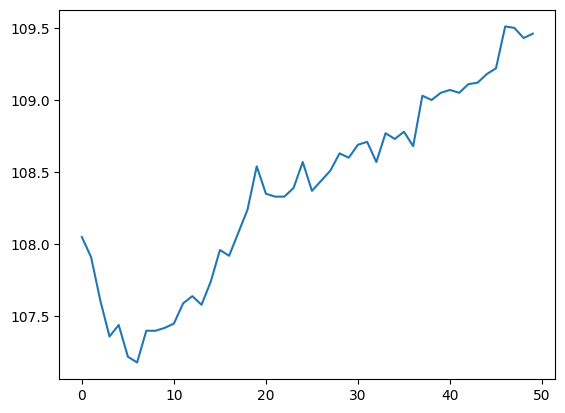

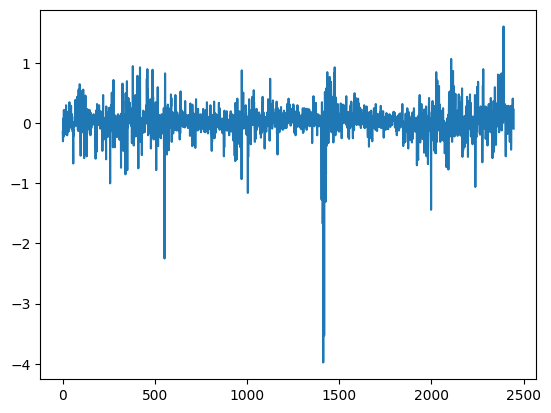

In [17]:
data_set_values = data.iloc[:, np.r_[2,7,11]].values
print(data_set_values)
#r_[2:4,4,5:9,11]
data.iloc[:, np.r_[2,7,11]]
#data_set_values.shape
pyplot.plot(data.iloc[0:50, 2], label='Effective date')
pyplot.show()
pyplot.plot(data["Next_Price_diff"], label='Effective date')
pyplot.show()


In [29]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set_values)
data_set_values = data_set_scaled
print(data_set_values.shape)

(2447, 3)


In [30]:
print( sc.data_min_)

[107.18  -3.98 107.18]


In [31]:
# multiple feature from data provided to the model
X = []
Y = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 30
n_forecast = 10
print(data_set_values.shape[0])
for j in range(data_set_values.shape[1] - 1):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_values.shape[0] - n_forecast + 1):#backcandles+2
        X[j].append(data_set_values[i-backcandles:i, j])
  
       
       
Y.append([])
for i in range(backcandles, data_set_values.shape[0] - n_forecast + 1):
    Y[0].append(data_set_values[i: i + n_forecast, -1])


#move axis from 0 to position 2
X= np.moveaxis(X, [0], [2])
Y= np.moveaxis(Y, [0], [2])
#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X =np.array(X)
Y = np.array(Y)
#X = X.reshape(X.shape[0], backcandles)
Y = Y.reshape(Y.shape[0], n_forecast)
y = Y
#yi = np.array(data_set_values[backcandles:,-1])
#y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(y)
print(X.shape)
print(y.shape)


2447
[[[0.01342178 0.72808587]
  [0.01126196 0.68694097]
  [0.00663376 0.65831843]
  ...
  [0.02051836 0.72450805]
  [0.02236964 0.73345259]
  [0.02190682 0.70661896]]

 [[0.01126196 0.68694097]
  [0.00663376 0.65831843]
  [0.00277692 0.66726297]
  ...
  [0.02236964 0.73345259]
  [0.02190682 0.70661896]
  [0.02329528 0.72808587]]

 [[0.00663376 0.65831843]
  [0.00277692 0.66726297]
  [0.00401111 0.72629696]
  ...
  [0.02190682 0.70661896]
  [0.02329528 0.72808587]
  [0.02360383 0.71556351]]

 ...

 [[0.95279235 0.68515206]
  [0.9501697  0.68157424]
  [0.94955261 0.70483005]
  ...
  [0.98210429 0.7549195 ]
  [0.97531626 0.6332737 ]
  [0.97577908 0.71735242]]

 [[0.9501697  0.68157424]
  [0.94955261 0.70483005]
  [0.94878124 0.70304114]
  ...
  [0.97531626 0.6332737 ]
  [0.97577908 0.71735242]
  [0.98025301 0.76386404]]

 [[0.94955261 0.70483005]
  [0.94878124 0.70304114]
  [0.95202098 0.74955277]
  ...
  [0.97577908 0.71735242]
  [0.98025301 0.76386404]
  [0.97917309 0.69946333]]]
[[0.0

In [32]:


# Preprocess date data (consider converting to numerical format)
# This example uses string representation for simplicity
#X = pd.to_datetime(X)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y_test.shape
#X_test.shape
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


(482, 10)

In [33]:
#model = Sequential()

#model.add(Dense(256, activation="relu", input_dim=7))
#model.add(BatchNormalization())
#model.add(Dropout(0.01))
act = "linear"
drop = 0.01



inputLayer = Input(shape=(X_train.shape[1], X_train.shape[2]))
#hidden1_lstm = LSTM(units=16,  return_sequences=False)(inputLayer)
hidden1_lstm = Flatten()(inputLayer)
#hidden2_lstm = LSTM(32, return_sequences=False,  dropout= drop)(hidden1_lstm)
#hidden1_lstm =  Conv1D(filters=64, kernel_size=10, activation=act, input_shape = (X_train.shape[1], X_train.shape[2]))(inputLayer)
#hidden2_lstm = Flatten()(hidden1_lstm)
#hidden1_lstm = MaxPooling1D(pool_size=4)(hidden1_lstm)

#hidden2_lstm = Flatten()(hidden1_lstm)
hidden2_lstm = Dense(1024, activation=act)(hidden1_lstm)

hidden3_dense = Dense(512, activation=act)(hidden2_lstm)
hidden4_dense = Dense(256, activation=act)(hidden3_dense)
for i in range(2):
   hidden4_dense = Dense(128, activation=act)(hidden4_dense)

out_dense = []
for i in range(y.shape[1]):
   out_dense.append(Dense(1, activation="linear")(hidden4_dense))

out_dense = keras.layers.concatenate(out_dense)
#out_dense = Dense(y.shape[1], activation="linear")(hidden3_dense)
model = keras.Model(inputs = inputLayer, outputs = out_dense)



#model.add(LSTM(units=64,  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

#model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Flatten())
# model.add(Dense(units=128))
# model.add(Dense(units=64 ))

#model.add(LSTM(64, return_sequences=False,  dropout= drop))

# model.add(Flatten())
# model.add(Dense(1024, activation=act))
# model.add(Dropout(drop))
# model.add(Dense(512, activation=act))

#model.add(Dense(32, activation=act))

# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.

#model.add(Dense(y.shape[1], activation="linear"))



lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
tnp.experimental_enable_numpy_behavior(
    prefer_float32=False, dtype_conversion_mode='legacy'
)
@tensorflow.function(autograph=True)
def custom_loss(y_true, y_pred):
 
 diff =  math_ops.squared_difference(y_pred, y_true)  #squared difference
 diff_temp = tnp.array([])
 for i in range(len(diff)):
    tensorflow.autograph.experimental.set_loop_options(
                shape_invariants=[(diff_temp, tensorflow.TensorShape([None]))]
            )
    coef = 1
    X = tnp.array([])
    for j in range(len(diff[i])):
       X = tnp.append(X, diff[i][j] * coef ) 
       coef+=1
    diff_temp = tnp.append(diff_temp, X)
 #print(diff)
 #loss = math_ops.reduce_mean(diff)
 #print(loss)   
    #print("finish")
 loss = keras.backend.mean(diff_temp) #mean over last dimension
 loss = loss 
 return loss


#'mean_squared_error'
# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer= Adam(learning_rate=lr_schedule), run_eagerly=False)

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
model.summary()
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=X.shape[0], verbose=1, callbacks=[es])

# Calculate predictions
PredTestSet = model.predict(X_train)
PredValSet = model.predict(X_test)

# Save predictions
#np.savetxt("trainresults.csv", PredTestSet, delimiter=",")
#np.savetxt("valresults.csv", PredValSet, delimiter=",")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30, 2)]              0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 60)                   0         ['input_3[0][0]']             
                                                                                                  
 dense_30 (Dense)            (None, 1024)                 62464     ['flatten_2[0][0]']           
                                                                                                  
 dense_31 (Dense)            (None, 512)                  524800    ['dense_30[0][0]']            
                                                                                            

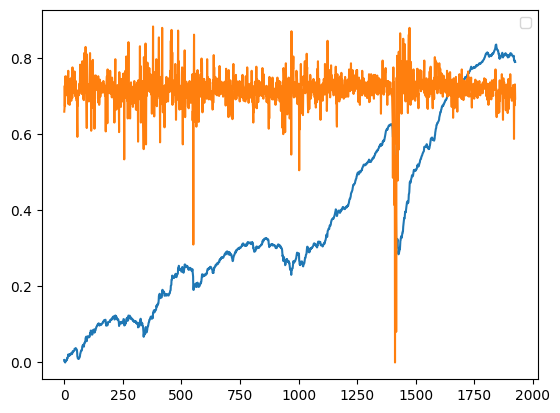

In [34]:
pyplot.plot(X_train[:,2])

pyplot.legend()
pyplot.show()

In [430]:
keras.utils.plot_model(model, show_shapes= True, show_layer_activations=True)
print(np.asarray(model.predict(X_test)).shape)

16/16 [==============================] - 0s 3ms/step
(482, 10)


In [36]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=X.shape[0], verbose=1, callbacks=[es])

Epoch 1/200
1/1 [==============================] - 0s 119ms/step - loss: 3.0550e-04 - val_loss: 3.4948e-04
Epoch 2/200
1/1 [==============================] - 0s 70ms/step - loss: 3.0456e-04 - val_loss: 3.4844e-04
Epoch 3/200
1/1 [==============================] - 0s 70ms/step - loss: 3.0363e-04 - val_loss: 3.4742e-04
Epoch 4/200
1/1 [==============================] - 0s 69ms/step - loss: 3.0271e-04 - val_loss: 3.4640e-04
Epoch 5/200
1/1 [==============================] - 0s 72ms/step - loss: 3.0180e-04 - val_loss: 3.4540e-04
Epoch 6/200
1/1 [==============================] - 0s 78ms/step - loss: 3.0090e-04 - val_loss: 3.4440e-04
Epoch 7/200
1/1 [==============================] - 0s 75ms/step - loss: 3.0001e-04 - val_loss: 3.4342e-04
Epoch 8/200
1/1 [==============================] - 0s 83ms/step - loss: 2.9913e-04 - val_loss: 3.4245e-04
Epoch 9/200
1/1 [==============================] - 0s 72ms/step - loss: 2.9825e-04 - val_loss: 3.4148e-04
Epoch 10/200
1/1 [===========================

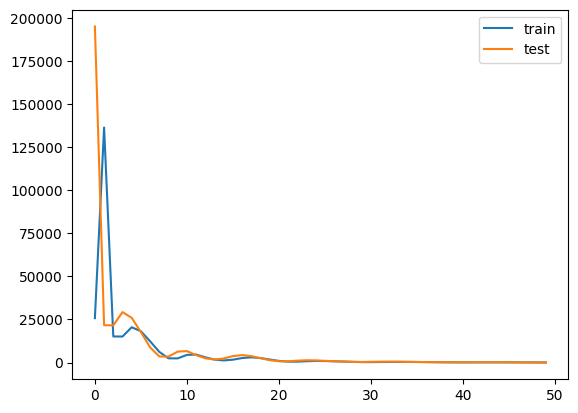

In [26]:

# Plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [37]:
#unscaled_data = sc.inverse_transform(scaled_data)
y_pred = model.predict(X_test) # * sc.data_min_[7] + (sc.data_max_[7] - sc.data_min_[7])
y_pred = np.array(y_pred).reshape((-1,y.shape[1]))
#X = np.array(y_pred).reshape((-1,y.shape[1]))
#y_pred = X
#print(X.shape)
y_test_inversed =  y_test * sc.data_min_[-1] + (sc.data_max_[-1] - sc.data_min_[-1])
#print(np.array(y_test_inversed).shape)

y_pred = y_pred  * sc.data_min_[-1] + (sc.data_max_[-1] - sc.data_min_[-1])
#y_pred=np.where(y_pred > 0.43, 1,0)

for i in range(10):
    print(y_pred[-i], y_test_inversed[-i])
   

print(np.asarray(y_pred).shape)
print(np.asarray(y_test_inversed).shape)
   

16/16 [==============================] - 0s 2ms/step
[147.3406  147.47815 147.39575 147.8757  148.2504  148.03015 147.3735
 148.22357 147.42538 148.1037 ] [148.27224622 148.32185128 148.27224622 148.4210614  147.61084542
 147.99115088 147.79273064 147.71005554 147.99115088 147.82580068]
[170.52927 170.29868 170.01686 170.0014  170.56992 169.61308 170.3371
 169.85062 170.64168 170.45885] [169.88351743 170.31342795 170.37956803 170.79294354 171.47087936
 171.3385992  171.4212743  171.81811478 172.         171.85118482]
[169.82248 169.75967 169.43213 169.53372 170.32019 169.87701 169.78139
 169.82858 170.47804 169.56363] [169.91658747 169.88351743 170.31342795 170.37956803 170.79294354
 171.47087936 171.3385992  171.4212743  171.81811478 172.        ]
[169.52805 169.13531 169.0422  169.30826 169.89105 168.98975 169.96675
 169.59624 169.99422 169.86057] [169.76777229 169.91658747 169.88351743 170.31342795 170.37956803
 170.79294354 171.47087936 171.3385992  171.4212743  171.81811478]
[169.

In [484]:
y_predd = [[164.46146, 157.44827, 175.57133],
[164.47305, 157.4592, 175.58517],
[164.25914, 157.26147, 175.33142],
[164.09756, 157.11252, 175.1396 ]]

y_truee = [[170.37956803, 170.79294354, 171.47087936],
[170.31342795, 170.37956803, 170.79294354],
[169.88351743, 170.31342795, 170.37956803],
[169.91658747, 169.88351743, 170.31342795]]

@tensorflow.function(autograph=True)
def custom_loss(y_true, y_pred):
 #diff =  math_ops.squared_difference(y_pred, y_true)  #squared difference
 #print(diff)
 trueList = tnp.array([])
 predList = tnp.array([])
 for i in range(len(y_pred)):
    coef = 1
    X = tnp.array([])
    for j in range(len(y_pred[i])):
       X = tnp.append(X, y_pred[i][j] * coef ) 
       coef+=1
    predList = tnp.append(predList, X)
 print(y_pred)
 print(predList)
 for i in range(len(y_true)):
    coef = 1
    X = tnp.array([])
    for j in range(len(y_true[i])):
       X = tnp.append(X, y_true[i][j] * coef ) 
       coef+=1
    trueList = tnp.append(trueList, X)
       #print(j)
    #print(coef)
    #print(diff[i])
 #print(diff)
 print(type(trueList))
 #trueList = tensorflow.TensorArray(dtype= list, size= 0, dynamic_size=True)
 #predList = tensorflow.TensorArray(dtype= list, size= 0, dynamic_size=True)
 trueList = tnp.reshape(trueList, (-1, 3))
 predList = tnp.reshape(predList, (-1, 3))
 print(y_true)
 print(trueList)
 diff =  math_ops.squared_difference(y_pred, y_true)  #squared difference
 diff_temp = tnp.array([])
 for i in range(len(diff)):
    tensorflow.autograph.experimental.set_loop_options(
                shape_invariants=[(predList, tensorflow.TensorShape([None]))]
            )
    coef = 1
    X = tnp.array([])
    for j in range(len(diff[i])):
       X = tnp.append(X, diff[i][j] * coef ) 
       coef+=1
    diff_temp = tnp.append(diff_temp, X)
 print("gi")
 print(diff_temp)
 #loss = math_ops.reduce_mean(diff)
 #print(loss)   
    #print("finish")
 loss = keras.backend.mean(diff_temp) #mean over last dimension
 loss = loss 
 return loss

print(custom_loss(y_true=y_truee, y_pred=y_predd))

[[164.46146, 157.44827, 175.57133], [164.47305, 157.4592, 175.58517], [164.25914, 157.26147, 175.33142], [164.09756, 157.11252, 175.1396]]
Tensor("concat_15:0", shape=(12,), dtype=float64)
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
[[170.37956803, 170.79294354, 171.47087936], [170.31342795, 170.37956803, 170.79294354], [169.88351743, 170.31342795, 170.37956803], [169.91658747, 169.88351743, 170.31342795]]
Tensor("Reshape_64:0", shape=(4, 3), dtype=float64)
gi
Tensor("concat_47:0", shape=(12,), dtype=float64)
tf.Tensor(146.19502449035645, shape=(), dtype=float64)


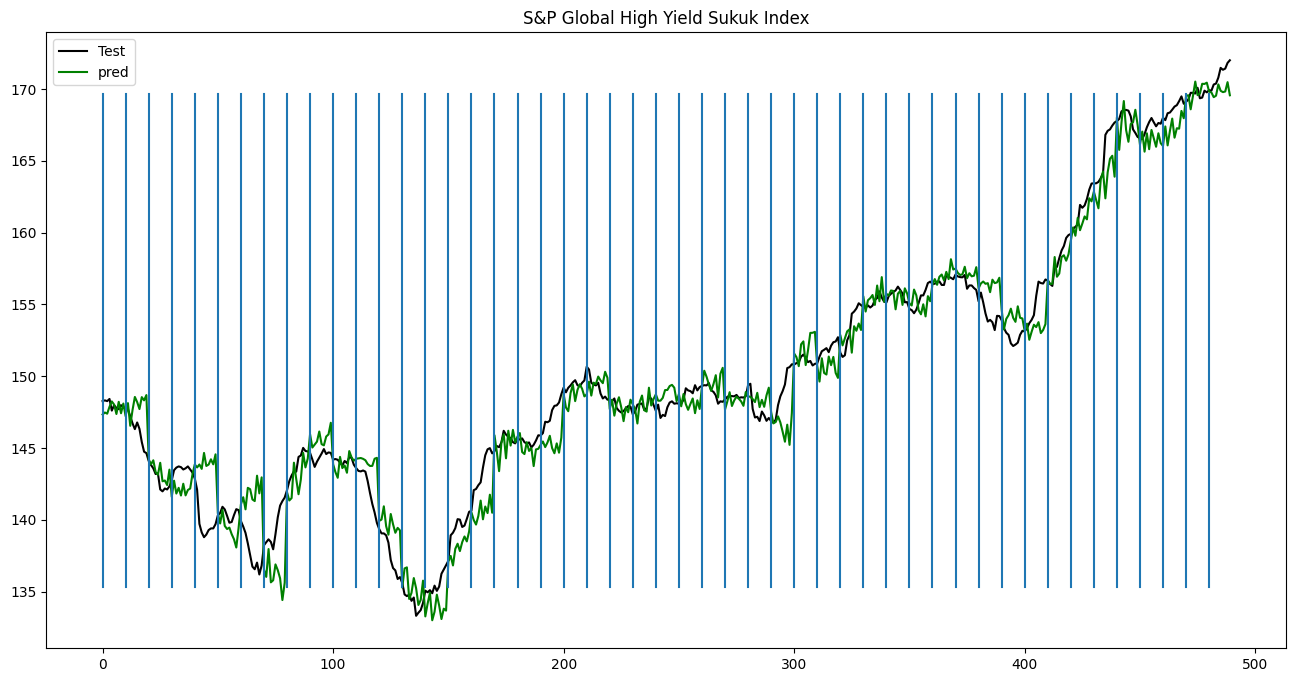

[170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135
 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135
 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135
 135 135 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135
 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135 135 135
 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135
 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135
 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135
 135 135 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135
 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135 135 135
 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135 135 135
 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135 135 135
 135 135 135 135 170 135 135 135 135 135 135 135 135 135 170 135 135 135
 135 135 135 135 135 135 170 135 135 135 135 135 13

(49, 10)

In [38]:
plt.figure(figsize=(16,8))
Y_test_inversed = []
Y_pred = []
splits = []


for i in range(0,int(0.2 * len(X)),n_forecast):
    Y_test_inversed.append(y_test_inversed[i])
    Y_pred.append(y_pred[i])
    splits.append(170)
    for _ in range(n_forecast-1):
        splits.append(135)

plt.plot( np.array(Y_test_inversed).reshape(-1), color = 'black', label = 'Test')
plt.plot(np.array(Y_pred).reshape(-1), color = 'green', label = 'pred')
for xc in range(0,int(0.2 * len(X)),n_forecast):
    plt.axvline(x=xc , ymax=0.9, ymin=0.1)
plt.title(name)   
plt.legend()
plt.show()
print(np.array(splits).reshape(-1))
Y_test_inversed = np.array(Y_test_inversed)
Y_test_inversed.reshape(-1)
Y_test_inversed.shape

61/61 [==============================] - 0s 2ms/step


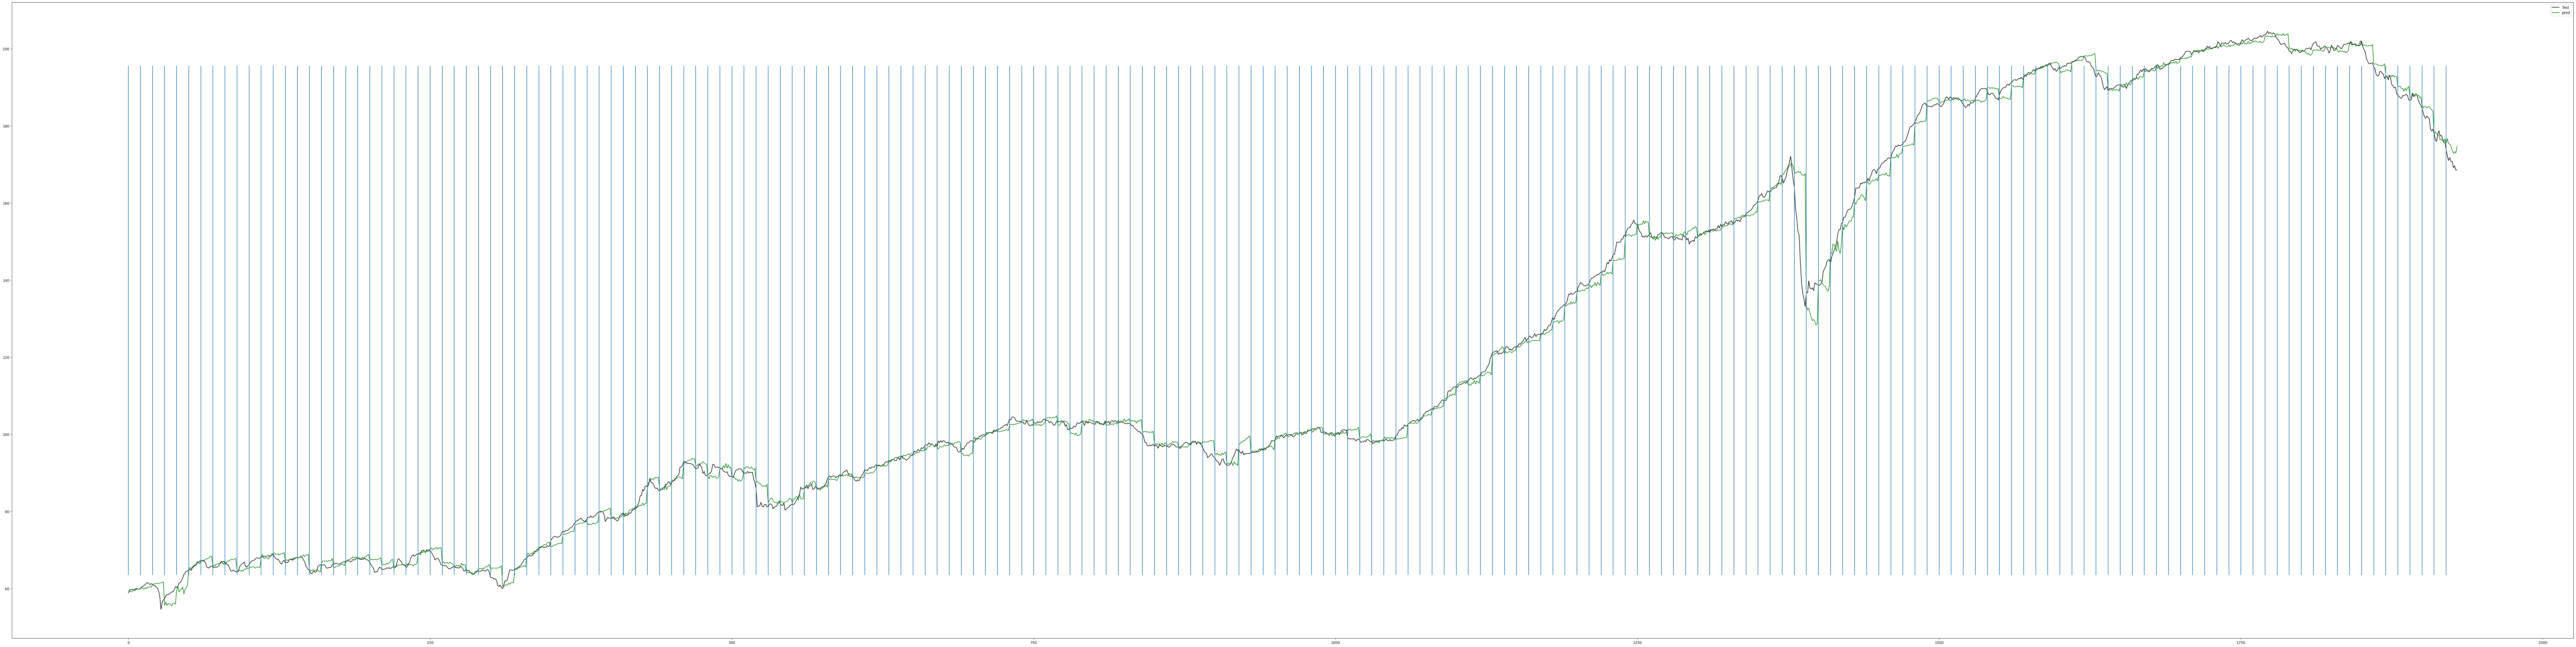

[170 135 135 ... 135 135 135]


(193, 10)

In [486]:
y_pred = model.predict(X_train) # * sc.data_min_[7] + (sc.data_max_[7] - sc.data_min_[7])
y_pred = np.array(y_pred).reshape((-1,y.shape[1]))
#X = np.array(y_pred).reshape((-1,y.shape[1]))
#y_pred = X
#print(X.shape)
y_train_inversed =  y_train * sc.data_min_[-1] + (sc.data_max_[-1] - sc.data_min_[-1])
#print(np.array(y_test_inversed).shape)

y_pred = y_pred  * sc.data_min_[-1] + (sc.data_max_[-1] - sc.data_min_[-1])

plt.figure(figsize=(128,32))
Y_train_inversed = []
Y_pred = []
splits = []


for i in range(0,int(0.8 * len(X)),n_forecast):
    Y_train_inversed.append(y_train_inversed[i])
    Y_pred.append(y_pred[i])
    splits.append(170)
    for _ in range(n_forecast-1):
        splits.append(135)

plt.plot( np.array(Y_train_inversed).reshape(-1), color = 'black', label = 'Test')
plt.plot(np.array(Y_pred).reshape(-1), color = 'green', label = 'pred')
for xc in range(0,int(0.8 * len(X)),n_forecast):
    plt.axvline(x=xc , ymax=0.9, ymin=0.1)
plt.legend()
plt.show()
print(np.array(splits).reshape(-1))
Y_train_inversed = np.array(Y_train_inversed)
Y_train_inversed.reshape(-1)
Y_train_inversed.shape

C:\Users\friha\AppData\Local\Temp\ipykernel_18896\1223803026.py:2: UserWarning: genfromtxt: Empty input file: "trainresults.csv"
  TestResults = np.genfromtxt("trainresults.csv", delimiter=",")


ValueError: x and y must have same first dimension, but have shapes (1926, 10) and (0,)

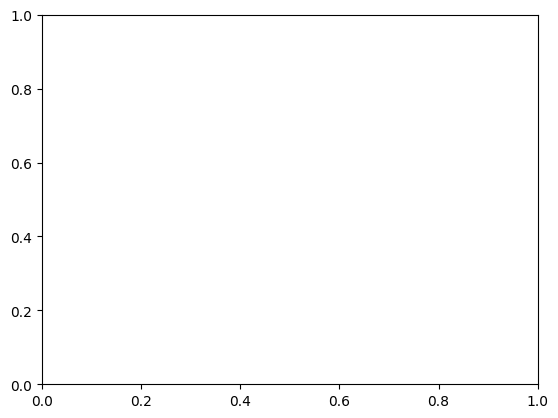

In [12]:

# Plot actual vs prediction for training set
TestResults = np.genfromtxt("trainresults.csv", delimiter=",")
plt.plot(y_train,TestResults,'ro')
plt.title('Training Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for training set
TestR2Value = r2_score(y_train,TestResults)
print("Training Set R-Square=", TestR2Value)

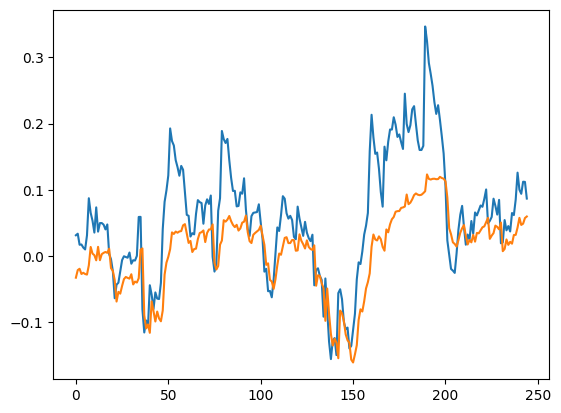

In [ ]:
pyplot.show()
val = []
for i in range(len(data_set) - train_size):
    val.append(y_test[train_size + i])
TestvalResults = numpy.genfromtxt("valresults.csv", delimiter=",")
#pyplot.plot(model.predict(data_set.iloc[0:90, 2:9]), label='Effective date')
pyplot.plot(val, label='Effective date')
pyplot.plot(TestvalResults, label='Effective date')


pyplot.show()